## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
# Load data
df = pd.read_csv('AZN-AstraZeneca.csv')

## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,41.610001,41.759998,41.480000,41.759998,36.845531,4590000
2019-03-04,41.730000,41.810001,41.389999,41.689999,36.783772,3948200
2019-03-05,41.560001,42.610001,41.560001,42.310001,37.330799,5668200
2019-03-06,42.360001,42.389999,41.930000,42.029999,37.083755,2490000
2019-03-07,41.610001,41.770000,41.330002,41.660000,36.757294,5283900
...,...,...,...,...,...,...
2024-05-24,78.129997,78.889999,78.080002,78.540001,78.540001,3566600
2024-05-28,77.779999,77.820000,76.489998,76.620003,76.620003,4199000
2024-05-29,76.129997,76.510002,75.800003,76.080002,76.080002,4653800


## Scale Data

In [4]:
# Select 'Close' column
data = df['Close'].values

In [5]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

## Split the data into train and test

In [6]:
# Define the size of train and test
train_size = int(len(data_scaled) * 0.7)
test_size = len(data_scaled) - train_size

# Split the data into train and test set
train_data = data_scaled[0 : train_size, :]
test_data = data_scaled[train_size : len(data_scaled), :]

## Create and add data into X, y

In [7]:
def add_data(data, sequence_length=1):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [8]:
# Reshape into X=t,t+1,t+2..t+60 and Y=t+60
sequence_length = 60

# Get last data for test
train_last_windowsize = train_data[-sequence_length:]

test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)

# Reshape inputs to [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Build Model

In [9]:
model = Sequential() # Encapsulate the sequence of the inner layers

# 4 LSTM layers
model.add(LSTM(units = 50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# 1 Dense layer
model.add(Dense(units=1)) 

# Optimizer
model.compile(optimizer = 'adam', loss='mean_squared_error')

D:\Anaconda\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training Model

In [10]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
28/28 - 12s - 421ms/step - loss: 0.0353
Epoch 2/50
28/28 - 3s - 121ms/step - loss: 0.0073
Epoch 3/50
28/28 - 3s - 109ms/step - loss: 0.0075
Epoch 4/50
28/28 - 5s - 178ms/step - loss: 0.0066
Epoch 5/50
28/28 - 3s - 91ms/step - loss: 0.0056
Epoch 6/50
28/28 - 3s - 112ms/step - loss: 0.0068
Epoch 7/50
28/28 - 5s - 172ms/step - loss: 0.0050
Epoch 8/50
28/28 - 3s - 101ms/step - loss: 0.0049
Epoch 9/50
28/28 - 3s - 107ms/step - loss: 0.0049
Epoch 10/50
28/28 - 3s - 112ms/step - loss: 0.0048
Epoch 11/50
28/28 - 3s - 117ms/step - loss: 0.0048
Epoch 12/50
28/28 - 2s - 85ms/step - loss: 0.0042
Epoch 13/50
28/28 - 3s - 105ms/step - loss: 0.0062
Epoch 14/50
28/28 - 3s - 113ms/step - loss: 0.0045
Epoch 15/50
28/28 - 3s - 108ms/step - loss: 0.0042
Epoch 16/50
28/28 - 5s - 165ms/step - loss: 0.0040
Epoch 17/50
28/28 - 3s - 104ms/step - loss: 0.0041
Epoch 18/50
28/28 - 3s - 121ms/step - loss: 0.0038
Epoch 19/50
28/28 - 5s - 178ms/step - loss: 0.0038
Epoch 20/50
28/28 - 2s - 87ms/step - loss

## Predict and Inverse Transform the Predictions

In [11]:
y_pred = model.predict(X_test)

# Inverse transform the predictions
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step


## Calculate the error of the model

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error, mean_absolute_error
# Evaluate the accuracy of test

test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_msle = mean_squared_log_error(y_test, y_pred)


print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)
print(f"MAE on Test dataset: ", test_mae)

MAPE on Test dataset:  0.017413183217147233
RMSE on Test dataset:  1.5324067784160522
MSLE on Test dataset:  0.00048413263566750937
MAE on Test dataset:  1.1982535072122953


## Predict Close price for 90 next days

In [13]:
# Select the last day of current index
last_date = df.index[-1]

# Add a new day after the last day
next_date = last_date + pd.DateOffset(days=1)

# Generate a list of index only starting from the next day in 90 days
index_next_90_days = pd.date_range(start=next_date, periods=90).tolist()

# Predict Close price for 90 next days
last_sequence_days = data_scaled[-sequence_length:].reshape(1, -1, 1)

y_next_90_days = []

for i in range(90):
    # Predict Close price for next day
    next_day_pred = model.predict(last_sequence_days)
    
    # Save the predict value
    y_next_90_days.append(next_day_pred[0][0])
    
    # Update information of the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

In [14]:
# Show the result of predict 90 next days 
y_next_90_days = scaler.inverse_transform(np.array(y_next_90_days).reshape(-1, 1))
print(y_next_90_days.flatten())

[75.43393  75.15164  74.8252   74.45117  74.06359  73.69613  73.36818
 73.08539  72.84493  72.64033  72.46433  72.31014  72.171776 72.04419
 71.92315  71.80531  71.68821  71.57022  71.45044  71.3286   71.20492
 71.07999  70.9546   70.82963  70.70598  70.58445  70.46575  70.350426
 70.23884  70.13122  70.02764  69.92807  69.83235  69.740295 69.65162
 69.566055 69.48332  69.40317  69.32534  69.24962  69.17584  69.10384
 69.03354  68.96483  68.89765  68.83197  68.76777  68.70501  68.643715
 68.58386  68.52543  68.468414 68.41282  68.35859  68.30571  68.25419
 68.20396  68.15499  68.107254 68.06072  68.01533  67.971054 67.92788
 67.885735 67.844604 67.80446  67.76527  67.727    67.68962  67.65312
 67.61747  67.58264  67.54862  67.51539  67.482925 67.4512   67.42022
 67.389946 67.36037  67.33147  67.30323  67.275635 67.24867  67.22233
 67.19658  67.17141  67.14682  67.12279  67.0993   67.07633 ]


## Model visualization

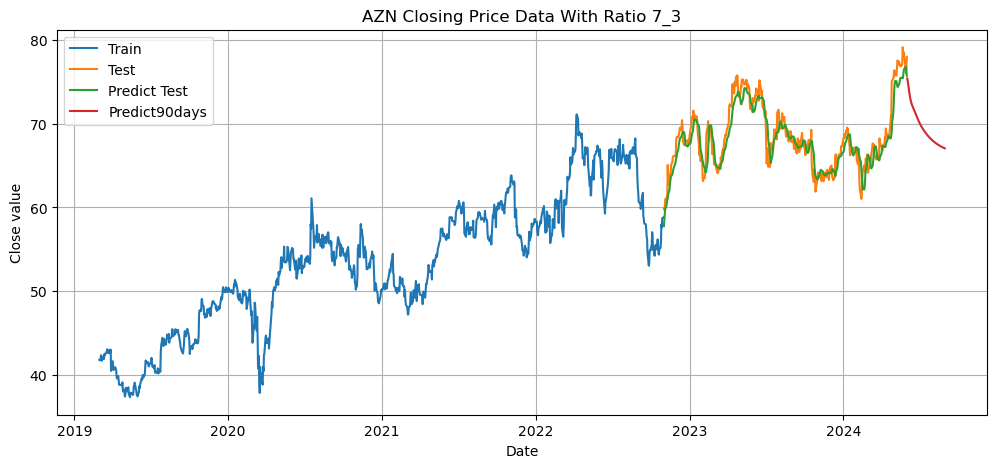

In [15]:
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df[:train_size].index, train_data)

# Test set
plt.plot(df[train_size:].index, test_data)

# Predict in test set
plt.plot(df[train_size:].index, y_pred)

# Predict 90 next days
plt.plot(index_next_90_days, y_next_90_days)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict90days'])
plt.grid()
plt.title("AZN Closing Price Data With Ratio 7_3")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('Image/RNN_73_90days_AZN.png')
plt.show()